**Input:** </br>
df_master </br>
**Output:** </br>
df_feats (master) </br>
df_master_index_train/val/test_index (split by hospenc_date), </br>

In [27]:
from utilities import *

# Features

In [28]:
import warnings
warnings.filterwarnings('ignore')

In [44]:
time_variable = ["Room Start Datetime", 
                      "Induction Datetime", 
                      "Incision Datetime", 
                      "Dressing Datetime", 
                      "Emergence Datetime", 
                      "Room End Datetime"]

anes_variable = ["Anesthesia Start Datetime", "Anesthesia Stop Datetime"]


continous_variable = ["ENCRYPTED_HOSP_ENCOUNTER",
                      "Age at Encounter",
                      "ASA (Anesth Record)", 
                      "ASA (Prior to Surgery)", 
                      "Charlson_Comorbidity_Index", 
                      "Admit Weight (kg)", 
                      "Admit Height (cm)",
                      "Admit BMI",]

categorical_variable = ["ENCRYPTED_HOSP_ENCOUNTER",
                        "Day of Week (CHAR)", 
                        "Type of Day", 
                        "Race", 
                        "Ethnicity", 
                        "Sex", 
                        "Marital Status", 
                        "Service", 
                        
                        "Emergent Y/N (Anesth Record)", 
                        "CPT 1", 
                        "Emergent Y/N (Prior to Surgery)", 
                        
                        "Anesthesia Type", 
                        "Admit Source",
                        "Payer"]

surgery_process_cat = ["ENCRYPTED_HOSP_ENCOUNTER","Anesthesia Block Y/N",
                      "Room Type", ]

Label = ["LOS", "LOS in Hours"]

In [30]:
df_master=pickle.load(open('/drives/drive1/home/changyu_yin/Desktop/PSG/PSG_AMIA_NEJM/intermediary/df_master_preprocessed.pkl','rb'))

## Time features

In [31]:
time_variable_array = df_master[time_variable]
anes_variable_array = df_master[anes_variable]

for col in anes_variable_array.columns:
    anes_variable_array[col] = pd.to_datetime(anes_variable_array[col]) 

for col in time_variable_array.columns:
    time_variable_array[col] = pd.to_datetime(time_variable_array[col]) 

In [32]:
start_to_induction = (time_variable_array['Induction Datetime'] - time_variable_array['Room Start Datetime'])/pd.Timedelta(minutes=1)
induction_to_incision = (time_variable_array['Incision Datetime'] - time_variable_array['Induction Datetime'])/pd.Timedelta(minutes=1)
incision_to_dressing = (time_variable_array['Dressing Datetime'] - time_variable_array['Incision Datetime'])/pd.Timedelta(minutes=1)
dressing_to_emergence = (time_variable_array['Emergence Datetime'] - time_variable_array['Dressing Datetime'])/pd.Timedelta(minutes=1)
emergency_to_end = (time_variable_array['Room End Datetime'] - time_variable_array['Emergence Datetime'])/pd.Timedelta(minutes=1)

anes_duration = (anes_variable_array['Anesthesia Stop Datetime'] - anes_variable_array['Anesthesia Start Datetime'])/pd.Timedelta(minutes=1)

In [33]:
df_time=pd.DataFrame({
             'ENCRYPTED_HOSP_ENCOUNTER':df_master['ENCRYPTED_HOSP_ENCOUNTER'],
             'start_to_induction':start_to_induction,
             'induction_to_incision':induction_to_incision,
             'incision_to_dressing':incision_to_dressing,
             'dressing_to_emergence':dressing_to_emergence,
             'emergency_to_end':emergency_to_end,
             'anes_duration':anes_duration})

In [34]:
df_time = df_time.groupby('ENCRYPTED_HOSP_ENCOUNTER').mean().reset_index()

## Continuous features

In [35]:
df_master["ASA (Prior to Surgery)"] = fill_missing_ASA(df_master["ASA (Anesth Record)"].values,  df_master["ASA (Prior to Surgery)"].values)
df_master["ASA (Anesth Record)"] = fill_missing_ASA(df_master["ASA (Prior to Surgery)"].values, df_master["ASA (Anesth Record)"].values)

In [36]:
df_cont = df_master[continous_variable].groupby('ENCRYPTED_HOSP_ENCOUNTER').mean().reset_index()

## Categorical features

In [37]:
df_cat_var = df_master[categorical_variable].fillna('MISSING_UNKNOWN')

In [38]:
df_cat_var_p1 = pd.get_dummies(df_cat_var,columns=categorical_variable[1:]).\
                groupby('ENCRYPTED_HOSP_ENCOUNTER').sum().reset_index()

In [39]:
df_cat_var_p2 = df_cat_var.\
                groupby('ENCRYPTED_HOSP_ENCOUNTER').size().\
                reset_index()
df_cat_var_p2.columns = ['ENCRYPTED_HOSP_ENCOUNTER','NUM_Surgeries_tot']

In [40]:
df_cat_var.shape,df_cat_var_p1.shape,df_cat_var_p2.shape

((161169, 14), (136647, 2867), (136647, 2))

In [41]:
df_cat_var = pd.concat([df_cat_var_p1,df_cat_var_p2.drop(columns=['ENCRYPTED_HOSP_ENCOUNTER'])],axis=1)

## Surgery Proces Categorical features

In [45]:
df_cat_var_surgery = df_master[surgery_process_cat].fillna('MISSING_UNKNOWN')

In [46]:
df_cat_var_surgery = pd.get_dummies(df_cat_var_surgery,columns=surgery_process_cat[1:]).\
                groupby('ENCRYPTED_HOSP_ENCOUNTER').sum().reset_index()

In [47]:
df_cat_var_surgery.shape

(136647, 21)

## Assemble

In [49]:
df_cat_var.shape,df_cont.shape,df_time.shape,df_cat_var_surgery.shape

((136647, 2868), (136647, 8), (136647, 7), (136647, 21))

In [50]:
df_feats_clinical = pd.merge(df_cat_var,df_cont,on='ENCRYPTED_HOSP_ENCOUNTER',how='left')

In [51]:
df_feats_SurgeryProcess = pd.merge(df_cat_var_surgery,df_time,on='ENCRYPTED_HOSP_ENCOUNTER',how = 'left')

In [52]:
df_feats_clinical.shape,df_feats_SurgeryProcess.shape

((136647, 2875), (136647, 27))

# Splitting

## index

In [20]:
hospenc_date_array = pd.to_datetime(df_master['Admit DateTime'])

In [52]:
hospenc_id_array_t = pd.DataFrame({'ENCRYPTED_HOSP_ENCOUNTER': df_master['ENCRYPTED_HOSP_ENCOUNTER'],
                          'Admit DateTime':hospenc_date_array})
len(hospenc_id_array_t)

161169

In [53]:
hospenc_id_array_t = hospenc_id_array_t.groupby('ENCRYPTED_HOSP_ENCOUNTER').agg({'Admit DateTime':'min'})
hospenc_id_array_t['year'] = hospenc_id_array_t['Admit DateTime'].dt.year
hospenc_id_array_t = hospenc_id_array_t.sort_values('Admit DateTime')
len(hospenc_id_array_t)

136647

In [54]:
min(hospenc_id_array_t['Admit DateTime']),max(hospenc_id_array_t['Admit DateTime'])

(Timestamp('2010-09-18 01:15:00'), Timestamp('2022-08-17 18:11:00'))

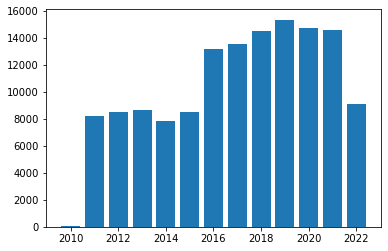

In [55]:
year_stat=hospenc_id_array_t.groupby('year').count().reset_index()
plt.bar(year_stat['year'],year_stat['Admit DateTime'])
plt.show()

In [57]:
year_stat['percent']=np.round(year_stat['Admit DateTime']/sum(year_stat['Admit DateTime'])*100,2)

In [64]:
num_train_val = int(np.ceil(len(hospenc_id_array_t)*0.9))
num_train = int(np.ceil(len(hospenc_id_array_t)*0.8))

In [61]:
hospenc_id_array_t = hospenc_id_array_t.reset_index()

In [70]:
hospenc_id_all = hospenc_id_array_t[['ENCRYPTED_HOSP_ENCOUNTER']]
hospenc_id_train_val = pd.DataFrame({'ENCRYPTED_HOSP_ENCOUNTER':hospenc_id_array_t.head(num_train_val)['ENCRYPTED_HOSP_ENCOUNTER']})
hospenc_id_train = pd.DataFrame({'ENCRYPTED_HOSP_ENCOUNTER':hospenc_id_array_t.head(num_train)['ENCRYPTED_HOSP_ENCOUNTER']})
hospenc_id_test = hospenc_id_all.loc[~hospenc_id_array_t['ENCRYPTED_HOSP_ENCOUNTER'].isin(hospenc_id_train_val['ENCRYPTED_HOSP_ENCOUNTER'].values)]
hospenc_id_val = hospenc_id_all.loc[(~hospenc_id_array_t['ENCRYPTED_HOSP_ENCOUNTER'].isin(hospenc_id_train['ENCRYPTED_HOSP_ENCOUNTER'].values))&
                                                                      (~hospenc_id_array_t['ENCRYPTED_HOSP_ENCOUNTER'].isin(hospenc_id_test['ENCRYPTED_HOSP_ENCOUNTER'].values))]
print(len(hospenc_id_train)+len(hospenc_id_test)+len(hospenc_id_val)-len(hospenc_id_all))
print(len(hospenc_id_train_val)-len(hospenc_id_train)-len(hospenc_id_val))
print(len(hospenc_id_train_val)+len(hospenc_id_test)-len(hospenc_id_all))

0
0
0


## split

In [72]:
df_master_index_all = df_master[['ENCRYPTED_ENCOUNTER', 
                                 'ENCRYPTED_MRN', 
                                 'ENCRYPTED_HOSP_ENCOUNTER',
                                 'CASE_NUMBER']]

In [75]:
df_master_index_train = df_master_index_all.loc[df_master_index_all['ENCRYPTED_HOSP_ENCOUNTER'].\
                                                isin(hospenc_id_train['ENCRYPTED_HOSP_ENCOUNTER'])].reset_index()
df_master_index_val = df_master_index_all.loc[df_master_index_all['ENCRYPTED_HOSP_ENCOUNTER'].\
                                                isin(hospenc_id_val['ENCRYPTED_HOSP_ENCOUNTER'])].reset_index()
df_master_index_test = df_master_index_all.loc[df_master_index_all['ENCRYPTED_HOSP_ENCOUNTER'].\
                                                isin(hospenc_id_test['ENCRYPTED_HOSP_ENCOUNTER'])].reset_index()
len(df_master_index_train)+len(df_master_index_val)+len(df_master_index_test)-len(df_master_index_all)

0

In [82]:
pickle.dump(df_master_index_all,open('/drives/drive1/home/changyu_yin/Desktop/PSG/PSG_AMIA_NEJM/split_index/df_master_index_all.pkl','wb'))
pickle.dump(df_master_index_train,open('/drives/drive1/home/changyu_yin/Desktop/PSG/PSG_AMIA_NEJM/split_index/df_master_index_train.pkl','wb'))
pickle.dump(df_master_index_val,open('/drives/drive1/home/changyu_yin/Desktop/PSG/PSG_AMIA_NEJM/split_index/df_master_index_val.pkl','wb'))
pickle.dump(df_master_index_test,open('/drives/drive1/home/changyu_yin/Desktop/PSG/PSG_AMIA_NEJM/split_index/df_master_index_test.pkl','wb'))

In [53]:
pickle.dump(df_feats_clinical,open('/drives/drive1/home/changyu_yin/Desktop/PSG/PSG_AMIA_NEJM/feature/df_feats_clinical.pkl','wb'))
pickle.dump(df_feats_SurgeryProcess,open('/drives/drive1/home/changyu_yin/Desktop/PSG/PSG_AMIA_NEJM/feature/df_feats_SurgeryProcess.pkl','wb'))

# Outcome labels

In [179]:
df_master_label = df_master[['ENCRYPTED_HOSP_ENCOUNTER','Surgery_End_Datetime','Dischg Date','Dischg DateTime','Admit DateTime','LOS','LOS in Hours']].drop_duplicates(ignore_index=True)
df_master_label['Admit DateTime'] = pd.to_datetime(df_master_label['Admit DateTime'])
df_master_label['Dischg Date'] = pd.to_datetime(df_master_label['Dischg Date'])
df_master_label['Dischg DateTime'] = pd.to_datetime(df_master_label['Dischg DateTime'])
df_master_label.shape

(136647, 7)

In [180]:
df_master_label['Dischg'] = np.where(~df_master_label['Dischg DateTime'].isna(),
                                     df_master_label['Dischg DateTime'],
                                     np.where(~df_master_label['Dischg Date'].isna(),
                                              df_master_label['Dischg Date'],
                                                  np.where(~df_master_label['LOS in Hours'].isna(),
                                                          df_master_label['Admit DateTime']+pd.to_timedelta(df_master_label['LOS in Hours'],unit='h'),
                                                           df_master_label['Admit DateTime']+pd.to_timedelta(df_master_label['LOS'],unit='d')
                                                          )
                                              )
                                        )

In [181]:
df_master_label['LOS_postoperative']= (df_master_label['Dischg'] - df_master_label['Surgery_End_Datetime'])/pd.Timedelta(days=1)

In [182]:
np.sum(df_master_label.LOS_postoperative<0),np.mean(df_master_label.LOS_postoperative<0)

(194, 0.0014197164957884183)

In [183]:
df_master_label_p1 = df_master_label[df_master_label['LOS_postoperative']>=0].reset_index(drop=True)
df_master_label_p2 = df_master_label[df_master_label['LOS_postoperative']<0].reset_index(drop=True)

In [184]:
df_master_label_p2['Dischg'] = np.where(~df_master_label_p2['LOS in Hours'].isna(),
                                     df_master_label_p2['Admit DateTime']+pd.to_timedelta(df_master_label_p2['LOS in Hours'],unit='h'),
                                     np.where(~df_master_label_p2['Dischg DateTime'].isna(),
                                             df_master_label_p2['Dischg DateTime'],
                                             np.where(~df_master_label_p2['Dischg Date'].isna(),
                                                      df_master_label_p2['Dischg Date'],
                                                      df_master_label_p2['Admit DateTime']+pd.to_timedelta(df_master_label_p2['LOS'],unit='d')
                                                     )
                                             )
                                     
                                    )

In [185]:
df_master_label_p2['LOS_postoperative']= (df_master_label_p2['Dischg'] - df_master_label_p2['Surgery_End_Datetime'])/pd.Timedelta(days=1)

In [186]:
np.sum(df_master_label_p2.LOS_postoperative<0),np.sum(df_master_label_p2.LOS_postoperative<0)/136647

(188, 0.0013758077381867146)

<AxesSubplot:>

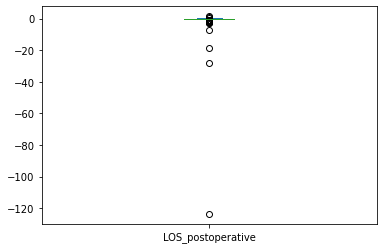

In [187]:
df_master_label_p2['LOS_postoperative'].plot(kind='box')

In [188]:
df_master[df_master['ENCRYPTED_HOSP_ENCOUNTER'].isin(df_master_label_p2['ENCRYPTED_HOSP_ENCOUNTER'][0:10])][['Dischg Date','Case Date', 'Admit DateTime', 'Dischg DateTime', 'LOS', 'LOS in Hours','Room End Datetime']]

,Dischg Date,Case Date,Admit DateTime,Dischg DateTime,LOS,LOS in Hours,Room End Datetime
12,2011-01-01,1/2/2011,12/31/2010 23:19,1/1/2011 19:45,0.0,39.333333,2011-01-02 19:09:00
95,2011-01-05,1/5/2011,1/5/2011 6:05,1/5/2011 8:00,0.0,1.916666,2011-01-05 10:12:00
184,2011-01-11,1/10/2011,1/11/2011 14:00,1/11/2011 16:58,0.0,2.966666,2011-01-13 14:58:00
506,2011-01-24,1/24/2011,12/19/2010 20:08,1/24/2011 4:44,0.0,848.600000,2011-01-24 10:46:00
542,2011-01-26,1/25/2011,1/25/2011 17:13,1/26/2011 2:30,0.0,9.283333,2011-01-26 04:07:00
1088,2011-02-16,2/17/2011,2/16/2011 9:31,2/16/2011 16:36,0.0,28.583333,2011-02-17 15:23:00
1162,2011-02-21,2/21/2011,2/21/2011 9:05,2/21/2011 12:06,0.0,3.016666,2011-02-21 15:05:00
1427,NaT,3/4/2011,3/4/2011 0:00,NaN,0.0,NaN,2011-03-04 11:58:00
1435,2011-03-04,3/4/2011,3/2/2011 8:40,3/4/2011 2:43,0.0,29.333333,2011-03-04 04:58:00
1441,2011-03-06,3/4/2011,3/4/2011 2:24,3/6/2011 23:24,0.0,69.000000,2011-03-07 03:57:00


In [189]:
df_master_label_p2['LOS_postoperative'] = np.where(df_master_label_p2['LOS_postoperative']<0,0,df_master_label_p2['LOS_postoperative'])

In [190]:
df_master_label = pd.concat([df_master_label_p1,df_master_label_p2])[['ENCRYPTED_HOSP_ENCOUNTER','LOS_postoperative']].reset_index(drop=True)
df_master_label.shape
len(df_master_label.ENCRYPTED_HOSP_ENCOUNTER),len(set(df_master_label.ENCRYPTED_HOSP_ENCOUNTER))

(136647, 136647)

In [191]:
df_master_label['LOS_postoperative'].min(),df_master_label['LOS_postoperative'].max(),df_master_label['LOS_postoperative'].mean(),df_master_label['LOS_postoperative'].median()

(0.0, 656.2597222222222, 5.1428873047172905, 3.1020833333333333)

In [192]:
np.quantile(df_master_label['LOS_postoperative'],0.75),np.quantile(df_master_label['LOS_postoperative'],0.9)

(6.041666666666667, 10.9375)

In [193]:
pickle.dump(df_master_label,open('/drives/drive1/home/changyu_yin/Desktop/PSG/PSG_AMIA_NEJM/feature/Outcome_labels.pkl','wb'))

In [6]:
df_master_label_priorDeath = df_master[['ENCRYPTED_HOSP_ENCOUNTER','IF_died_prior_dischg']].drop_duplicates(ignore_index=True)
df_master_label_30dDeath = df_master[['ENCRYPTED_HOSP_ENCOUNTER','IF_died_postsurg30d']].drop_duplicates(ignore_index=True)
df_master_label_90dDeath = df_master[['ENCRYPTED_HOSP_ENCOUNTER','IF_died_postsurg90d']].drop_duplicates(ignore_index=True)

In [8]:
df_master_label_priorDeath.shape,df_master_label_30dDeath.shape,df_master_label_90dDeath.shape

((136647, 2), (136647, 2), (136647, 2))

In [9]:
pickle.dump(df_master_label_priorDeath,open('/drives/drive1/home/changyu_yin/Desktop/PSG/PSG_AMIA_NEJM/feature/Outcome_labels_death_postdischg.pkl','wb'))
pickle.dump(df_master_label_30dDeath,open('/drives/drive1/home/changyu_yin/Desktop/PSG/PSG_AMIA_NEJM/feature/Outcome_labels_death_30d.pkl','wb'))
pickle.dump(df_master_label_90dDeath,open('/drives/drive1/home/changyu_yin/Desktop/PSG/PSG_AMIA_NEJM/feature/Outcome_labels_death_90d.pkl','wb'))